In [1]:
# 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00


In [3]:
# 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Input,Dense,Dropout,BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.multioutput import ClassifierChain
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path='/content/drive/MyDrive/KT-BigProject/'

In [31]:
data_df=pd.read_csv(path+'최종통합본.csv')

In [7]:
data_df['Cutline_rate'].value_counts()

,count
Cutline_rate,
1,573
2,269
3,34


In [26]:
# size에 대한 전처리
data_df['Supply_type'] = data_df['Supply_type'].str.extract('(\d+\.?\d*)').astype(float)

In [32]:
# 데이터 분리 (X: 특징, y: 타겟)
X = data_df.drop(columns='Cutline_rate')
y = data_df['Cutline_rate']

# RandomOverSampler로 특정 클래스 oversampling
oversampler = RandomOverSampler(sampling_strategy={2: 500, 3: 500}, random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Resampled 데이터프레임 생성
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['Cutline_rate'] = y_resampled

# Oversampled 데이터프레임 확인
print("\nResampled class distribution:")
print(df_resampled['Cutline_rate'].value_counts())

# 결과 확인
print("\nResampled DataFrame:")
print(df_resampled)


Resampled class distribution:
Cutline_rate
1    573
2    500
3    500
Name: count, dtype: int64

Resampled DataFrame:
         Name            Address   Latitude   Longitude Supply_type  \
0     S-HOUSE      성동구 고산자로17길 9  37.567360  127.035712         21B   
1     S-HOUSE    성동구 고산자로17길 9-1  37.567382  127.035586         21B   
2       STAY온    관악구 남부순환로157길 3  37.484155  126.918585         17B   
3       STAY온    관악구 남부순환로157길 3  37.484155  126.918585         26B   
4       STAY온     관악구 남부순환로 1519  37.479901  126.940463         17B   
...       ...                ...        ...         ...         ...   
1568   낙원가우디움  구로구 고척로27마길 26-11  37.506061  126.847235         22B   
1569     최강타워    관악구 남부순환로180길 6  37.483945  126.930623         39A   
1570  상봉동양엔파트        중랑구 망우로 266  37.596959  127.090344         38B   
1571     최강타워    관악구 남부순환로180길 6  37.483945  126.930623         39A   
1572    비전하우스    양천구 곰달래로1길 36-1  37.532691  126.831685         19B   

      Applicant_type  Units 

# oversampling된 모델 분류 성능 체크하기 : Catboost

In [37]:
trial_df=df_resampled.copy()

cols=['Name','Address','Counts_daiso', 'Counts_supermarket', 'Counts_laundry',
       'Counts_pharmacy','Latitude','Longitude']


trial_df=trial_df.drop(columns=cols)

In [12]:
%matplotlib inline

In [38]:
# [0] 예시: 데이터 준비
# trial_df 내의 'Cutline_rate', 'Cutline_score'를 타겟으로 분리
X = trial_df.drop(columns=['Cutline_rate', 'Cutline_score'])
y_rate = trial_df['Cutline_rate']
y_score = trial_df['Cutline_score']

# 범주형 피처(컬럼명 리스트)
cat_features = ['Supply_type']

# [1] Train-Test Split
X_train, X_test, y_rate_train, y_rate_test, y_score_train, y_score_test = train_test_split(
    X, y_rate, y_score,
    test_size=0.2,
    random_state=24
)

# [2] 분류 모델: CatBoostClassifier (학습 과정 기록)
classifier = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    cat_features=cat_features,
    verbose=100,  # 학습 로그 100번 마다 출력
    one_hot_max_size=10,
    task_type='GPU'
)

# 학습 과정 기록
classifier.fit(
    X_train, y_rate_train,
    eval_set=(X_test, y_rate_test),  # 검증 데이터
    use_best_model=True,  # 성능이 가장 좋은 모델 사용
    early_stopping_rounds=10,
    plot=True  # 학습 곡선 시각화
)

# Train/Test 분류 예측
y_rate_pred_train = classifier.predict(X_train).astype(int)
y_rate_pred_test = classifier.predict(X_test).astype(int)

# [3] 분류 결과를 새 피처로 추가
X_train_reg = X_train.copy()
X_train_reg['pred_rate'] = y_rate_pred_train

X_test_reg = X_test.copy()
X_test_reg['pred_rate'] = y_rate_pred_test

# [4] 회귀 모델: CatBoostRegressor (학습 과정 기록)
regressor = CatBoostRegressor(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='RMSE',
    cat_features=cat_features,
    verbose=100,  # 학습 로그 출력
    task_type='GPU'
)

# 학습 과정 기록
regressor.fit(
    X_train_reg, y_score_train,
    eval_set=(X_test_reg, y_score_test),  # 검증 데이터
    early_stopping_rounds=10,
    use_best_model=True,  # 성능이 가장 좋은 모델 사용
    plot=True  # 학습 곡선 시각화
)

# Test 데이터 예측
y_score_pred = regressor.predict(X_test_reg)

y_score_pred.round().astype(int)

# 결과 확인
print('Rate : ')
print(classification_report(y_rate_test,y_rate_pred_test))
print('Rate CM:')
print(confusion_matrix(y_rate_test,y_rate_pred_test))
print('Score MAE:',mean_absolute_error(y_score_test,y_score_pred))
print('Score R2:',r2_score(y_score_test,y_score_pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0066764	test: 1.0089269	best: 1.0089269 (0)	total: 12.5ms	remaining: 12.5s
100:	learn: 0.2160141	test: 0.2812633	best: 0.2812633 (100)	total: 1.03s	remaining: 9.17s
200:	learn: 0.1380837	test: 0.2282452	best: 0.2282452 (200)	total: 1.95s	remaining: 7.75s
300:	learn: 0.0991285	test: 0.2057753	best: 0.2057753 (300)	total: 2.86s	remaining: 6.64s
400:	learn: 0.0759174	test: 0.1907754	best: 0.1907754 (400)	total: 3.77s	remaining: 5.64s
bestTest = 0.1825565883
bestIteration = 485
Shrink model to first 486 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.2837605	test: 2.2959470	best: 2.2959470 (0)	total: 27.8ms	remaining: 27.7s
100:	learn: 1.2061027	test: 1.5749708	best: 1.5745253 (96)	total: 2.63s	remaining: 23.4s
200:	learn: 1.0936135	test: 1.5390339	best: 1.5384065 (196)	total: 6.91s	remaining: 27.5s
bestTest = 1.538406503
bestIteration = 196
Shrink model to first 197 iterations.
Rate : 
              precision    recall  f1-score   support

           1       0.94      0.89      0.91       115
           2       0.87      0.92      0.89        97
           3       0.98      1.00      0.99       103

    accuracy                           0.93       315
   macro avg       0.93      0.93      0.93       315
weighted avg       0.93      0.93      0.93       315

Rate CM:
[[102  13   0]
 [  6  89   2]
 [  0   0 103]]
Score MAE: 0.9986881081588698
Score R2: 0.5827153638376168


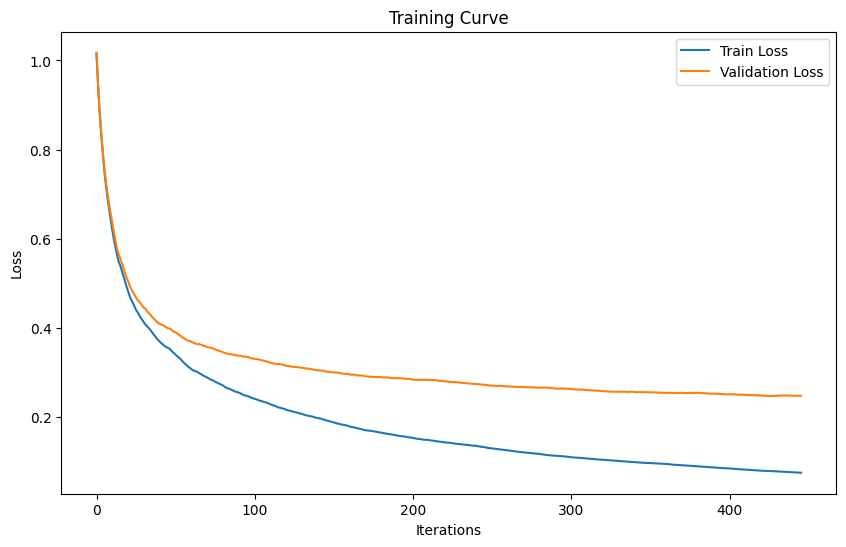

In [22]:
# 학습 과정 결과 가져오기
evals_result = classifier.evals_result_

# 학습 곡선 그리기
train_loss = evals_result['learn']['MultiClass']
val_loss = evals_result['validation']['MultiClass']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Curve')
plt.legend()
plt.show()


In [15]:
evals_result

{'learn': {'MultiClass': [1.0134608300589392,
   0.9431514477682956,
   0.8772638167285732,
   0.8263843588838409,
   0.7785733266054764,
   0.7366251467721635,
   0.7026714932005157,
   0.6738268059691184,
   0.6478616830642191,
   0.6235805429035179,
   0.5989978243185167,
   0.5789487947415275,
   0.5610920544457576,
   0.54089139627333,
   0.527099969110695,
   0.5131085289016454,
   0.49880597727237846,
   0.4857021848907171,
   0.47288504190201375,
   0.46050177013944316,
   0.45046241625353023,
   0.4401362930627609,
   0.42924475529339085,
   0.4209060219275694,
   0.4124469869497483,
   0.40386813000752086,
   0.39662554128230904,
   0.38918230997321646,
   0.38187784670846636,
   0.37624066845607196,
   0.36971182532769525,
   0.36472648815462305,
   0.3584976645958681,
   0.35405435918122236,
   0.34964106171913373,
   0.3448227318424607,
   0.34012932018587305,
   0.3359818674023821,
   0.3313690665194468,
   0.32768528306882366,
   0.3242074183256078,
   0.3204023739677983

# EBM을 통해서 feature들에 대해서 생각해보자

In [9]:
pip install interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 50.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 14.1 MB/s eta 0:00:00
   ━━

In [28]:
trial_df=df_resampled.copy()

cols=['Name','Address','Latitude','Infra_score','Counts_daiso', 'Counts_supermarket', 'Counts_laundry',
       'Counts_pharmacy', 'Counts_cafe', 'Counts_convstore','Quarter']

trial_df=trial_df.drop(columns=cols)

In [29]:
trial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273 entries, 0 to 1272
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Longitude       1273 non-null   float64
 1   Supply_type     1273 non-null   float64
 2   Applicant_type  1273 non-null   int64  
 3   Units           1273 non-null   int64  
 4   Gender          1273 non-null   int64  
 5   Shared          1273 non-null   int64  
 6   Cutline_score   1273 non-null   int64  
 7   Year            1273 non-null   int64  
 8   Applied_type    1273 non-null   int64  
 9   Counts_station  1273 non-null   int64  
 10  people          1273 non-null   int64  
 11  Rate1           1273 non-null   int64  
 12  Rate2           1273 non-null   int64  
 13  Rate3           1273 non-null   int64  
 14  Cutline_rate    1273 non-null   int64  
dtypes: float64(2), int64(13)
memory usage: 149.3 KB


In [30]:
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 데이터 분할
X = trial_df.drop(columns='Cutline_score')
y = trial_df['Cutline_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# EBM 회귀 모델 학습
ebm = ExplainableBoostingRegressor(random_state=42)
ebm.fit(X_train, y_train)

# 예측 및 평가
y_pred = ebm.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

# 글로벌 설명 시각화
from interpret import show
global_explanation = ebm.explain_global()
show(global_explanation)



Mean Squared Error: 2.53
R2 Score: 0.51
